In [ ]:
!pip install torch==2.0
!pip install ftfy regex tqdm
!pip install openai-clip==1.0.1
!pip install torchvision==0.15.1
!pip install transformers==4.34.1
!pip install opensearch-py==2.3.2

In [10]:
import sys
import torch
import sagemaker
import opensearchpy
import boto3
print(f"Python version :: {sys.version}")
print(f"Torch Version :: ${torch.__version__}")
device = "cuda:0" if torch.cuda.is_available() else "cpu" 
print(f"Device details ::{device}")
print(f"SageMaker Version :: {sagemaker.__version__}")
print(f"OpenSearchPy version:: {opensearchpy.__version__}")
print(f"Boto3 version:: {boto3.__version__}")

Python version :: 3.10.6 (main, Oct  7 2022, 20:19:58) [GCC 11.2.0]
Torch Version :: $2.0.0+cu117
Device details ::cpu
SageMaker Version :: 2.192.0
OpenSearchPy version:: (2, 3, 2)
Boto3 version:: 1.28.63


In [ ]:
import json
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import clip
from transformers import CLIPProcessor, CLIPModel

json_path = './fashion_data/train_data.json'
image_path = './fashion_data/images/train/'


with open(json_path, 'r') as f:
    input_data = []
    for line in f:
        obj = json.loads(line)
        input_data.append(obj)


# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


# Choose computation device
device = "cuda:0" if torch.cuda.is_available() else "cpu" 

# Load pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# Define a custom dataset
class image_title_dataset():
    def __init__(self, list_image_path,list_txt):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title  = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        return image, title

# use your own data
list_image_path = []
list_txt = []
for item in input_data:
  img_path = image_path + item['image_path'].split('/')[-1]
  caption = item['product_title'][:40]
  list_image_path.append(img_path)
  list_txt.append(caption)

dataset = image_title_dataset(list_image_path, list_txt)
train_dataloader = DataLoader(dataset, batch_size=1000, shuffle=True) 

# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


if device == "cpu":
  model.float()

# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) 


# Specify the loss function
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# Train the model
num_epochs = 4
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        optimizer.zero_grad()

        images,texts = batch 
        
        images= images.to(device)
        texts = texts.to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

        # Backward pass
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else : 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), 'new_clip_model.pt')

In [ ]:
# create the opensearch client
# replace my-test-domain with correct opensearch domain name 

from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
import boto3

host = 'my-test-domain.us-east-1.aoss.amazonaws.com' # cluster endpoint, for example: my-test-domain.us-east-1.aoss.amazonaws.com
region = 'us-east-1'
service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)

client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)

In [ ]:
#create the vector index

import json
index_name = "indian-fashion-index" 

index_body = {
    "mappings": { 
        "properties": {
            "image_path": {"type": "text"}, 
            "image_product_description": {"type": "text"}, 
            "image_brand": {"type": "text"}, 
            "image_class": {"type": "text"}, 
            "image_url": {"type": "text"}, 
            "image_vector": {
                "type": "knn_vector", 
                "dimension": 512, 
                "method": 
                {
                    "engine": "nmslib",
                    "space_type": "cosinesimil",
                    "name": "hnsw",
                    "parameters": {"ef_construction": 512, "m": 16},
                }, 
            },
        }
    },
    "settings": {
        "index": {
            "number_of_shards": 2, 
            "knn.algo_param": {"ef_search": 512}, 
            "knn": True,
        } 
    },
}

try:
    response = client.indices.create(index_name, body=index_body) 
    print(json.dumps(response, indent=2))
except Exception as ex: print(ex)

# describe new vector index
try:
    response = client.indices.get("indian-fashion-index") 
    print(json.dumps(response, indent=2))
except Exception as ex: print(ex)

In [ ]:
# Generate embeddings and store embeddings in  local files 
import os
import json
import clip
from PIL import Image
import torch
import torchvision.models as models

# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the saved CLIP model and preprocessing pipeline
model, preprocess = clip.load("ViT-B/32", device=device)
model.load_state_dict(torch.load('new_clip_model.pt', map_location=device))
model.eval()  # Set the model to evaluation mode

# Assuming you have a function `create_image_embedding` already defined
def create_image_embedding(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device) 
    with torch.no_grad():
        image_features = model.encode_image(image) 
    return image_features.tolist()[0]

# Paths to your JSON files
json_file_paths = ['./fashion_data/val_data.json','./fashion_data/test_data.json']


# Limit the number of records to process in each block
block_size = 1000

# Loop through each JSON file
for json_file_path in json_file_paths:
    with open(json_file_path, 'r') as json_file:
        # Process records in blocks of block_size
        documents = []
        for line_num, line in enumerate(json_file):
            try:
                # Load each line as a separate JSON object
                record = json.loads(line)

                image_path = record['image_path']
                image_product_description = record['product_title']
                image_brand = record['brand']
                image_class = record['class_label']
                image_url = record['image_url']

                # Assuming you have a function `create_image_embedding` already defined
                image_vector = create_image_embedding("./fashion_data/"+image_path)

                # Create the embedding_request_body
                embedding_request_body = {
                    "image_path": image_path,
                    "image_product_description": image_product_description,
                    "image_brand": image_brand,
                    "image_class": image_class,
                    "image_url": image_url,
                    "image_vector": image_vector
                }

                # Add the current record to the list of documents
                documents.append(embedding_request_body)

                # Check if it's time to write a block of documents
                if line_num > 0 and line_num % block_size == 0:
                    # Write the documents to a file
                    block_num = line_num // block_size
                    output_file_path = f"embedding_requests_{os.path.basename(json_file_path)}_block{block_num}.json"
                    with open(output_file_path, 'w') as output_file:
                        json.dump(documents, output_file, indent=2)

                    print(f"Processed {len(documents)} records and saved to {output_file_path}")

                    # Reset the documents list for the next block
                    documents = []
            except Exception as ex:
                print(f"Error processing record: {ex}")

        # Check if there are remaining documents after processing all lines
        if documents:
            # Write the remaining documents to a file
            output_file_path = f"embedding_requests_{os.path.basename(json_file_path)}_block{block_num + 1}.json"
            with open(output_file_path, 'w') as output_file:
                json.dump(documents, output_file, indent=2)

            print(f"Processed {len(documents)} records and saved to {output_file_path}")


In [ ]:
# Retrieve the saved embeddings from the json files in the embedding_data/ folder
# And Save these embeddings in OpenSearch Serverless 

import json
import os

from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
from opensearchpy import helpers
from opensearchpy.helpers import bulk
import boto3

# replace my-test-domain with correct opensearch domain name 
host = 'my-test-domain.us-east-1.aoss.amazonaws.com' # cluster endpoint, for example: my-test-domain.us-east-1.aoss.amazonaws.com
region = 'us-east-1'
service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)

client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)

# Directory containing the JSON files
json_files_directory = "./embedding_data"


# Iterate through each JSON file
for filename in os.listdir(json_files_directory):
    if filename.startswith("embedding_requests") and filename.endswith(".json"):
        file_path = os.path.join(json_files_directory, filename)

        # Load JSON file
        with open(file_path, "r") as file:
            data = json.load(file)

        print(f"Staring indexing for :: {filename}")

        # Use the bulk API to insert documents for the current file
        success, failed = bulk(
            client,
            data,
            index="indian-fashion-index",  # Replace with your OpenSearch index name
            raise_on_exception=True
        )

        print(f"Indexed {success} documents successfully, {failed} documents failed for file: {filename}")


In [2]:
# Now we will test by generating a text embedding directly from the model new_clip_model.pt 
# and then retrieving the semantically similar images from Open Search
# This is an example of semantically similar text to image search retrieval

import os
import json
import clip
from PIL import Image
import torch
import torchvision.models as models
import boto3
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the saved CLIP model and preprocessing pipeline
model, preprocess = clip.load("ViT-B/32", device=device)
model.load_state_dict(torch.load('new_clip_model.pt', map_location=device))
model.eval()  # Set the model to evaluation mode

def create_text_embedding(text):
    text = clip.tokenize([text]).to(device) 
    with torch.no_grad():
        text_features = model.encode_text(text) 
    return text_features.tolist()[0]

# replace my-test-domain with correct opensearch domain name 
host = 'my-test-domain.us-east-1.aoss.amazonaws.com' # cluster endpoint, for example: my-test-domain.us-east-1.aoss.amazonaws.com
region = 'us-east-1'
service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)

client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20
)


# query Opensearch index  using text embedding
text_embedding = create_text_embedding("green saree with golden embroidery")
query = {  "size": 10,
       "_source": {"excludes": ["image_vector"]}, 
       "query": {
        "knn": { 
            "image_vector": {
                    "vector": text_embedding,
                    "k": 10, 
            }
        } 
      },
    }
try:
    text_based_search_response = client.search(body=query, 
    index="indian-fashion-index")
    print(json.dumps(text_based_search_response, indent=2))
except Exception as ex: 
    print(ex)

{
  "took": 1294,
  "timed_out": false,
  "_shards": {
    "total": 0,
    "successful": 0,
    "skipped": 0,
    "failed": 0
  },
  "hits": {
    "total": {
      "value": 60,
      "relation": "eq"
    },
    "max_score": 0.60787606,
    "hits": [
      {
        "_index": "indian-fashion-index",
        "_id": "1%3A0%3AFjeUyYsBqT4Rnfr2bX9I",
        "_score": 0.60787606,
        "_source": {
          "image_product_description": "SKiran's Assamese Machine-Weaving Poly Silk Mekhela Chador Saree - Dn3867 Mekhla Sador (Parrotgreen)",
          "image_class": "saree",
          "image_path": "images/val/283.jpeg",
          "image_brand": "S Kiran's",
          "image_url": "https://m.media-amazon.com/images/I/81iiOdHnbYL._AC_UL320_.jpg"
        }
      },
      {
        "_index": "indian-fashion-index",
        "_id": "1%3A0%3AlzeUyYsBqT4Rnfr205KC",
        "_score": 0.6078368,
        "_source": {
          "image_product_description": "Geeta Handicrafts Women's Ikat Hand Block Prin

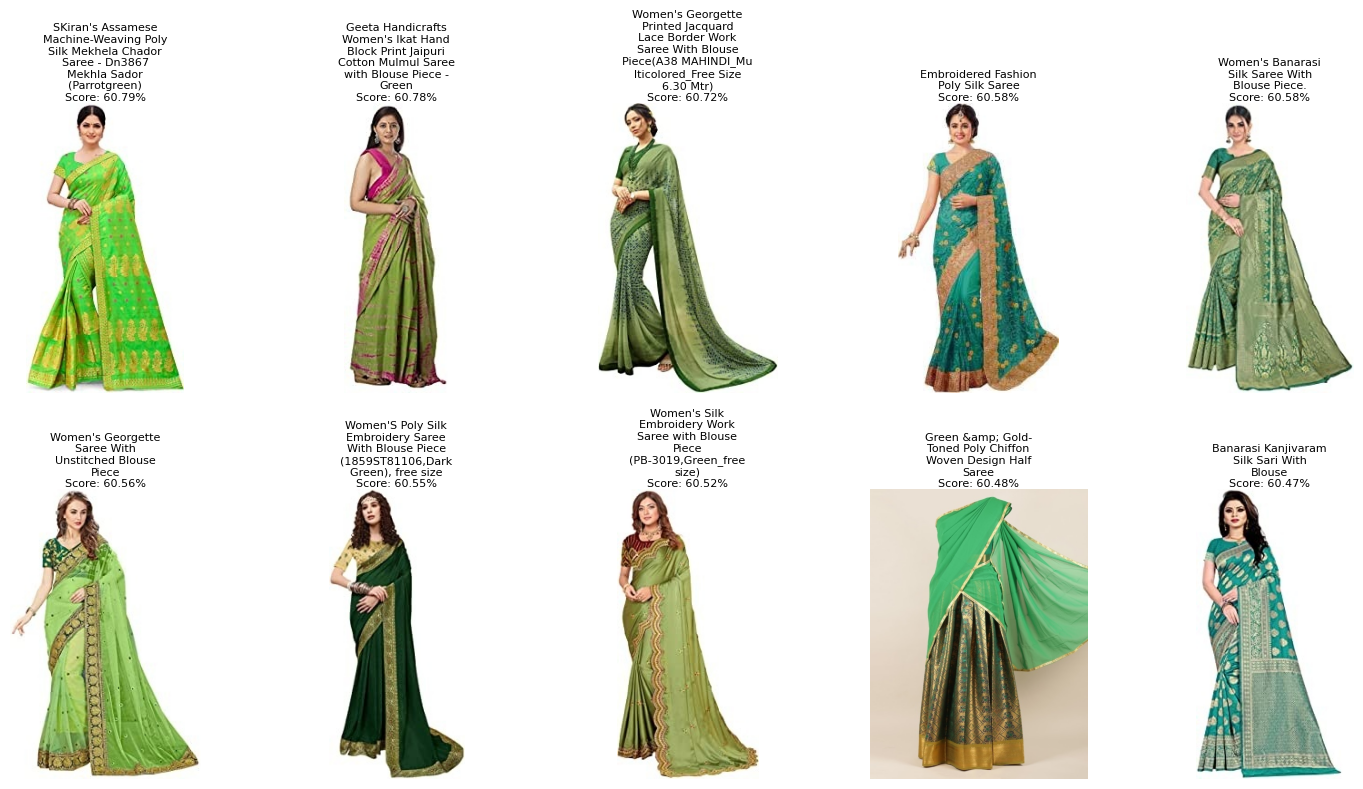

In [3]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import textwrap

# Display images and metadata
rows = 2
columns = 5
fig = plt.figure(figsize=(15, 8))

for index, value in enumerate(text_based_search_response["hits"]["hits"], 1): 
    ax = fig.add_subplot(rows, columns, index)
    image_path = value["_source"]["image_path"]
    image = np.array(Image.open(f'./fashion_data/{image_path}'))

    # Display the image
    ax.imshow(image)
    ax.axis("off") 

    # Display product description and score below the image
    product_description = value["_source"]["image_product_description"]
    wrapped_description = "\n".join(textwrap.wrap(product_description, width=20))
    
    score = f'Score: {value["_score"]:.2%}'
    
    # Set title and description below the image
    title = f'{wrapped_description}\n{score}'
    ax.set_title(title, fontsize=8, pad=2)

plt.tight_layout()
plt.show()


In [ ]:
!bash build_model_tar.sh clip-troubleshooting-demo

In [ ]:
!mkdir -p code

In [ ]:
%%writefile code/clip_inference.py

import io
import torch
import clip
from PIL import Image
import json
import logging
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

# ENCODE_TYPE could be IMAGE or TEXT
ENCODE_TYPE = os.environ.get("ENCODE_TYPE", "TEXT")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# defining model and loading weights to it.
def model_fn(model_dir):
    model, preprocess = clip.load("ViT-B/32", device=device)
    model.load_state_dict(torch.load(os.path.join(model_dir, 'new_clip_model.pt'), map_location=device))
    model.eval()  # Set the model to evaluation mode
    
    # Load the state dictionary from the saved .pt file
    saved_state_dict = torch.load(os.path.join(model_dir, 'new_clip_model.pt'), map_location=torch.device('cpu'))

    # Check if the state dictionaries are the same
    are_equal = all(torch.allclose(model.state_dict()[key], saved_state_dict[key]) for key in model.state_dict())

    if are_equal:
        print("State dictionaries are the same!")
    else:
        print("State dictionaries are different.")
    return {"model_obj": model, "preprocess_fn": preprocess}


def load_from_bytearray(request_body):
    
    return image

# data loading
def input_fn(request_body, request_content_type):
    assert request_content_type in (
        "application/json",
        "application/x-image",
    ), f"{request_content_type} is an unknown type."
    if request_content_type == "application/json":
        data = json.loads(request_body)["inputs"]
        print(f" Data IS :::: {data}")
    elif request_content_type == "application/x-image":
        image_as_bytes = io.BytesIO(request_body)
        data = Image.open(image_as_bytes)
    return data


# inference
def predict_fn(input_object, model):
    model_obj = model["model_obj"]
    # for image preprocessing
    preprocess_fn = model["preprocess_fn"]
    assert ENCODE_TYPE in ("TEXT", "IMAGE"), f"{ENCODE_TYPE} is an unknown encode type."

    # preprocessing
    if ENCODE_TYPE == "TEXT":
        input_ = clip.tokenize(input_object).to(device)
    elif ENCODE_TYPE == "IMAGE":
        input_ = preprocess_fn(input_object).unsqueeze(0).to(device)

    # inference
    with torch.no_grad():
        if ENCODE_TYPE == "TEXT":
            prediction = model_obj.encode_text(input_)
            print('prediction of text in model')
            print(prediction)
        elif ENCODE_TYPE == "IMAGE":
            prediction = model_obj.encode_image(input_)
            print('prediction of image in model')
            print(prediction)
    return prediction

# Serialize the prediction result into the desired response content type
def output_fn(predictions, content_type):
    assert content_type == "application/json"
    res = predictions.cpu().numpy().tolist()
    return json.dumps(res)

In [ ]:
%%writefile code/requirements.txt
ftfy
regex
tqdm
torchvision==0.15.1
transformers==4.34.1
openai-clip==1.0.1

In [ ]:
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role, Session
from sagemaker.serverless.serverless_inference_config import ServerlessInferenceConfig
from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

# below bucket name corresponds to the bucket that has the packaged model
# this s3 bucket name was also passed as parameter to build_model_tar.sh in the above steps

s3_bucket_name='clip-troubleshooting-demo'

role = get_execution_role()
shared_params = dict(
    entry_point="clip_inference.py",
    source_dir="code",
    role=role,
    model_data=f"s3://{s3_bucket_name}/models/clip/model.tar.gz",
    framework_version="2.0.0",
    py_version="py310",
)

clip_image_model = PyTorchModel(
    env={'MODEL_NAME': 'pretrained_clip_model.pt', "ENCODE_TYPE": "IMAGE"},
    name="clip-image-model",
    **shared_params
)

clip_text_model = PyTorchModel(
    env={'MODEL_NAME': 'pretrained_clip_model.pt', "ENCODE_TYPE": "TEXT"},
    name="clip-text-model",
    **shared_params
)

clip_text_model.deploy(
    instance_type='ml.c5.4xlarge',
    initial_instance_count=1,
    serverless_inference_config=ServerlessInferenceConfig(memory_size_in_mb=6144),
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    wait=True
)

clip_image_model.deploy(
    instance_type='ml.c5.4xlarge',
    initial_instance_count=1,
    serverless_inference_config=ServerlessInferenceConfig(memory_size_in_mb=6144),
    serializer=IdentitySerializer(content_type="application/x-image"),
    deserializer=JSONDeserializer(),
    wait=True
)


In [ ]:
#Now we do the text search for the semantically similiar images with  the deployed endpoint for the CLIP model on sagemaker
from sagemaker.predictor import Predictor
import json
import ast
import torch
import numpy as np

image_endpoint2 = 'clip-image-model-2023-11-07-13-31-24-809'
image_predictor2 = Predictor(image_endpoint2)
image_predictor2.content_type = 'application/x-image'

text_endpoint2 = 'clip-text-model-2023-11-07-13-28-14-227'
text_predictor2 = Predictor(text_endpoint2)
text_predictor2.content_type = 'application/json'

def encode_name2(item_name):
    input_data = {"inputs": [f"{item_name}"]}
    input_json = json.dumps(input_data)
    payload = input_json.encode('utf-8')
    res = text_predictor2.predict(data=payload)
    res_list = ast.literal_eval(res.decode("utf-8"))
    print(res_list)  # Print the list of floats
    return res_list

text_features2 = torch.tensor(np.array(encode_name2("Green blouse with golden border"))).reshape(1, -1)
# print(f"Text features Shape: {text_features2.shape}")
# print(f"Text Features to be indexed in OpenSearch :: {text_features2.tolist()[0]}" )


# query Opensearch index  using text embedding
text_embedding = text_features2.tolist()[0]
query = {  "size": 10,
       "_source": {"excludes": ["image_vector"]}, 
       "query": {
        "knn": { 
            "image_vector": {
                    "vector": text_embedding,
                    "k": 10, 
            }
        } 
      },
    }
try:
    text_based_search_response = client.search(body=query, 
    index="indian-fashion-index")
    print(json.dumps(text_based_search_response, indent=2))
except Exception as ex: 
    print(ex)


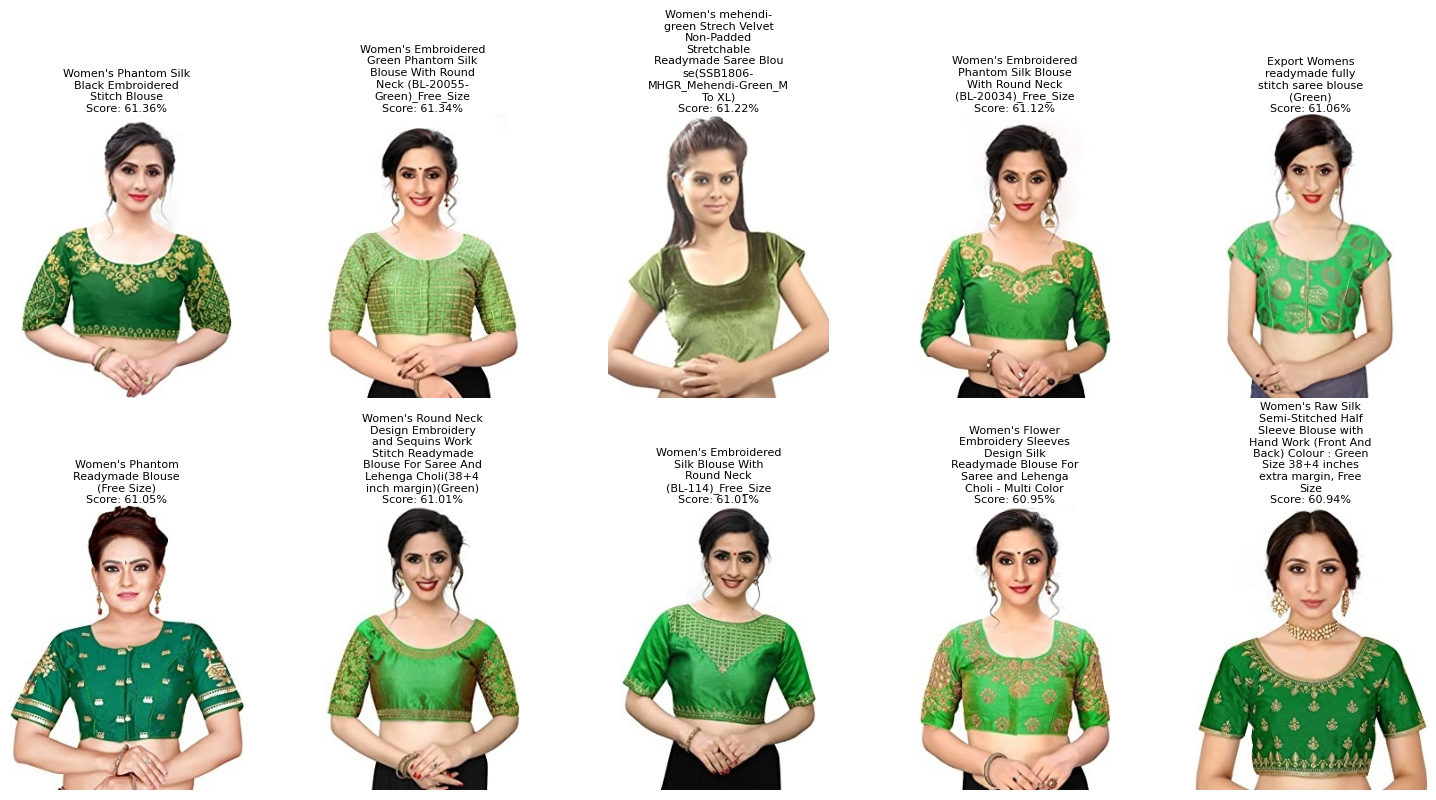

In [17]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import textwrap

# Display images and metadata
rows = 2
columns = 5
fig = plt.figure(figsize=(15, 8))

for index, value in enumerate(text_based_search_response["hits"]["hits"], 1): 
    ax = fig.add_subplot(rows, columns, index)
    image_path = value["_source"]["image_path"]
    image = np.array(Image.open(f'./fashion_data/{image_path}'))

    # Display the image
    ax.imshow(image)
    ax.axis("off") 

    # Display product description and score below the image
    product_description = value["_source"]["image_product_description"]
    wrapped_description = "\n".join(textwrap.wrap(product_description, width=20))
    
    score = f'Score: {value["_score"]:.2%}'
    
    # Set title and description below the image
    title = f'{wrapped_description}\n{score}'
    ax.set_title(title, fontsize=8, pad=2)

plt.tight_layout()
plt.show()

In [5]:
#Another example of  image based semantic  search by accessing the deployed endpoint on sagemaker
from sagemaker.predictor import Predictor
import json
import ast
import torch
import numpy as np

image_endpoint2 = 'clip-image-model-2023-11-07-13-31-24-809'
image_predictor2 = Predictor(image_endpoint2)
image_predictor2.content_type = 'application/x-image'

text_endpoint2 = 'clip-text-model-2023-11-07-13-28-14-227'
text_predictor2 = Predictor(text_endpoint2)
text_predictor2.content_type = 'application/json'

def encode_image2(file_name):    
    with open(file_name, "rb") as f:
        payload = f.read()
        payload = bytearray(payload)
    # Read image into memory
    res = image_predictor2.predict(data=payload)
    # Decode the byte string and convert it to a list of floats
    res_list = ast.literal_eval(res.decode("utf-8"))
    # print(res_list)  # Print the list of floats
    return res_list

# Path to the image you want to evaluate
image_path = "./man_in_redkurta.jpeg"
image_features2 = torch.tensor(np.array(encode_image2(image_path))).reshape(1, -1)
print(f"Image features Shape: {image_features2.shape}")
print(f"Image Features to be indexed in OpenSearch :: {image_features2.tolist()[0]}" )

# query Opensearch index  using text embedding
image_embedding = image_features2.tolist()[0]
query = {  "size": 10,
       "_source": {"excludes": ["image_vector"]}, 
       "query": {
        "knn": { 
            "image_vector": {
                    "vector": image_embedding,
                    "k": 10, 
            }
        } 
      },
    }
try:
    image_based_search_response = client.search(body=query, 
    index="indian-fashion-index")
    print(json.dumps(image_based_search_response, indent=2))
except Exception as ex: 
    print(ex)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Image features Shape: torch.Size([1, 512])
Image Features to be indexed in OpenSearch :: [0.14241579174995422, 0.2609381675720215, 0.006036337465047836, -0.178744837641716, 0.0073691122233867645, -0.10040484368801117, 0.2193947434425354, 0.47152313590049744, -0.1775674968957901, 0.054915573447942734, -0.016912344843149185, 0.15594413876533508, 0.3651258945465088, 0.03267678618431091, -0.020068302750587463, 0.12935757637023926, 0.7832241058349609, 0.07609321177005768, 0.07537944614887238, -0.20490826666355133, 0.0034976303577423096, 0.13063444197177887, -0.003763362765312195, -0.10746881365776062, 0.

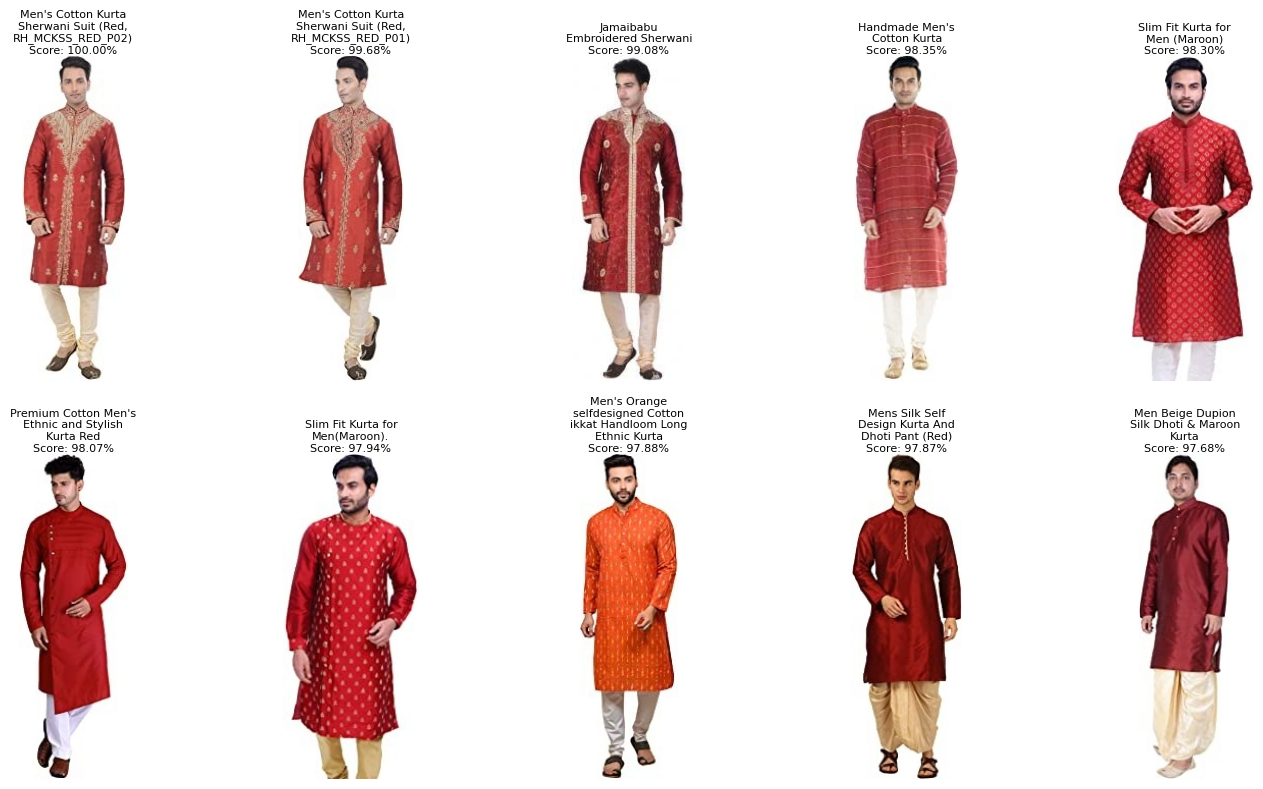

In [6]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import textwrap

# Display images and metadata
rows = 2
columns = 5
fig = plt.figure(figsize=(15, 8))

for index, value in enumerate(image_based_search_response["hits"]["hits"], 1): 
    ax = fig.add_subplot(rows, columns, index)
    image_path = value["_source"]["image_path"]
    image = np.array(Image.open(f'./fashion_data/{image_path}'))

    # Display the image
    ax.imshow(image)
    ax.axis("off") 

    # Display product description and score below the image
    product_description = value["_source"]["image_product_description"]
    wrapped_description = "\n".join(textwrap.wrap(product_description, width=20))
    
    score = f'Score: {value["_score"]:.2%}'
    
    # Set title and description below the image
    title = f'{wrapped_description}\n{score}'
    ax.set_title(title, fontsize=8, pad=2)

plt.tight_layout()
plt.show()

In [ ]:
# if you want to build a full stack application, then copy the images to an s3 bucket,
# these images will be used to display on the website and will be retrieved by the backend API logic.
!aws s3 cp --recursive ./fashion_data/images/ s3://<copy to your s3 bucket>/images/